In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

In [2]:
# disable some of the tf/keras training warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

# suppress untraced functions warning
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
# Pre-trained pose estimation model from Google Mediapipe
mp_pose = mp.solutions.pose

# Supported Mediapipe visualization tools
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    """
    This function detects human pose estimation keypoints from video frames
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    """
    This function draws keypoints and landmarks detected by the human pose estimation model
    """
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [6]:
def extract_keypoints(results):
    """
    Processes and organizes the keypoints detected from the pose estimation model 
    to be used as inputs for the exercise decoder models
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [7]:
def get_video_info(video_path):
    """
    Get video properties like FPS, width, height, and frame count
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return fps, width, height, total_frames

In [8]:
def process_video_to_keypoints(video_path, target_sequence_length, pose_model):
    """
    Process a video file and extract keypoints for each frame
    """
    cap = cv2.VideoCapture(video_path)
    keypoints_sequence = []
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame sampling if video is longer than target sequence
    if total_frames > target_sequence_length:
        # Sample frames evenly across the video
        frame_indices = np.linspace(0, total_frames - 1, target_sequence_length, dtype=int)
    else:
        # Use all frames and pad if necessary
        frame_indices = list(range(total_frames))
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Only process frames we want to sample
        if frame_count in frame_indices:
            # Make detection
            image, results = mediapipe_detection(frame, pose_model)
            
            # Extract keypoints
            keypoints = extract_keypoints(results)
            keypoints_sequence.append(keypoints)
        
        frame_count += 1
        
        # Break if we've processed enough frames
        if len(keypoints_sequence) >= target_sequence_length:
            break
    
    cap.release()
    
    # Pad sequence if it's shorter than target length
    while len(keypoints_sequence) < target_sequence_length:
        # Repeat the last frame or use zeros
        if len(keypoints_sequence) > 0:
            keypoints_sequence.append(keypoints_sequence[-1])
        else:
            keypoints_sequence.append(np.zeros(33*4))
    
    return np.array(keypoints_sequence[:target_sequence_length])


In [9]:
VIDEO_FOLDER_PATH = r"C:\Users\pheno\Downloads\work\excercises" 
DATA_PATH = os.path.join(os.getcwd(), 'data') 

In [10]:
# Make directory if it does not exist yet
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [11]:
VIDEO_EXTENSIONS = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm']

In [12]:
actions = []
if os.path.exists(VIDEO_FOLDER_PATH):
    actions = [folder for folder in os.listdir(VIDEO_FOLDER_PATH) 
               if os.path.isdir(os.path.join(VIDEO_FOLDER_PATH, folder))]
    actions = np.array(sorted(actions))
else:
    print(f"Video folder path '{VIDEO_FOLDER_PATH}' does not exist!")
    print("Please update the VIDEO_FOLDER_PATH variable with the correct path to your video folder.")
    exit()

print(f"Found exercise classes: {actions}")
num_classes = len(actions)

Found exercise classes: ['curl' 'lunge' 'plank' 'situp' 'squat']


In [13]:
sequence_length = 30

# Colors associated with each exercise
colors = [(245,117,16), (117,245,16), (16,117,245)]
while len(colors) < len(actions):
    colors.append((np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)))

# Process videos and extract keypoints
print("Processing videos and extracting keypoints...")

# Build folder paths for processed data
for action in actions:     
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))  
    except:
        pass

# Process each video and extract keypoints
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    sequence_counter = 0
    
    for idx, action in enumerate(actions):
        action_folder = os.path.join(VIDEO_FOLDER_PATH, action)
        print(f"Processing {action} videos...")
        
        # Get all video files in the action folder
        video_files = []
        for file in os.listdir(action_folder):
            if any(file.lower().endswith(ext) for ext in VIDEO_EXTENSIONS):
                video_files.append(file)
        
        print(f"Found {len(video_files)} videos for {action}")
        
        for video_idx, video_file in enumerate(video_files):
            video_path = os.path.join(action_folder, video_file)
            print(f"Processing {video_file} ({video_idx + 1}/{len(video_files)})")
            
            try:
                # Process video and extract keypoints
                keypoints_sequence = process_video_to_keypoints(video_path, sequence_length, pose)
                
                # Create sequence folder
                sequence_folder = os.path.join(DATA_PATH, action, str(sequence_counter))
                os.makedirs(sequence_folder, exist_ok=True)
                
                # Save each frame's keypoints
                for frame_num, keypoints in enumerate(keypoints_sequence):
                    npy_path = os.path.join(sequence_folder, f"{frame_num}.npy")
                    np.save(npy_path, keypoints)
                
                sequence_counter += 1
                
            except Exception as e:
                print(f"Error processing {video_file}: {str(e)}")
                continue

print("Finished processing all videos!")

Processing videos and extracting keypoints...
Processing curl videos...
Found 102 videos for curl
Processing 1 .mp4 (1/102)
Processing 10.mp4 (2/102)
Processing 11.mp4 (3/102)
Processing 12.mp4 (4/102)
Processing 13.mp4 (5/102)
Processing 14.mp4 (6/102)
Processing 15.mp4 (7/102)
Processing 2 .mp4 (8/102)
Processing 3.mp4 (9/102)
Processing 4 .mp4 (10/102)
Processing 5 .mp4 (11/102)
Processing 6.mp4 (12/102)
Processing 7.mp4 (13/102)
Processing 8.mp4 (14/102)
Processing 9.mp4 (15/102)
Processing barbell biceps curl_1.mp4 (16/102)
Processing barbell biceps curl_10.mp4 (17/102)
Processing barbell biceps curl_11.mp4 (18/102)
Processing barbell biceps curl_12.mp4 (19/102)
Processing barbell biceps curl_13.mp4 (20/102)
Processing barbell biceps curl_14.mp4 (21/102)
Processing barbell biceps curl_15.mp4 (22/102)
Processing barbell biceps curl_16.mp4 (23/102)
Processing barbell biceps curl_17.mp4 (24/102)
Processing barbell biceps curl_18.mp4 (25/102)
Processing barbell biceps curl_19.mp4 (26/

In [14]:
# Create label map
label_map = {label:num for num, label in enumerate(actions)}


In [15]:
# Load and organize processed training data
print("Loading processed keypoint data...")
sequences, labels = [], []

for action in actions:
    action_data_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_data_path):
        continue
        
    sequence_folders = [f for f in os.listdir(action_data_path) 
                       if os.path.isdir(os.path.join(action_data_path, f))]
    
    for sequence_folder in sequence_folders:
        sequence_path = os.path.join(action_data_path, sequence_folder)
        window = []
        
        # Load keypoints for each frame in the sequence
        for frame_num in range(sequence_length):
            frame_path = os.path.join(sequence_path, f"{frame_num}.npy")
            if os.path.exists(frame_path):
                res = np.load(frame_path)
                window.append(res)
            else:
                # If frame doesn't exist, use zeros
                window.append(np.zeros(33*4))
        
        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[action])


Loading processed keypoint data...


In [16]:
# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

if len(X) == 0:
    print("No data found! Please check your video folder structure and paths.")
    exit()

Dataset shape: X=(338, 30, 132), y=(338, 5)


In [17]:
# Calculate input dimensions
num_input_values = X.shape[2]  # Should be 33*4 = 132 for pose landmarks

# Split into training, validation, and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)
print(f"Validation set: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")

Training set: X_train=(304, 30, 132), y_train=(304, 5)
Validation set: X_val=(51, 30, 132), y_val=(51, 5)
Test set: X_test=(34, 30, 132), y_test=(34, 5)


In [18]:
# Callbacks to be used during neural network training 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
# Fix the checkpoint callback to use proper file path
checkpoint_path = os.path.join(os.getcwd(), 'best_model.keras')
chkpt_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq='epoch')


In [19]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Hyperparameters
batch_size = 32
max_epochs = 500

In [20]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [21]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, num_input_values))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

In [22]:
# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)

In [23]:
# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print("Starting model training...")
history = AttnLSTM.fit(X_train, y_train, 
                       batch_size=batch_size, 
                       epochs=max_epochs, 
                       validation_data=(X_val, y_val), 
                       callbacks=callbacks)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 132)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 512)   │    796,672 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 512, 30)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512, 30)   │        930 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 30, 512)   │          0 │ dense[0][0]       │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mul       │ (None, 30, 512)   │          0 │ bidirectional[0]… │
│ (Multiply)          │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 15360)     │          0 │ attention_mul[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │  7,864,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      2,565 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,664,999 (33.05 MB)

 Trainable params: 8,664,999 (33.05 MB)

 Non-trainable params: 0 (0.00 B)

None
Starting model training...
Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - categorical_accuracy: 0.2006 - loss: 2.4295 - val_categorical_accuracy: 0.3137 - val_loss: 1.4574 - learning_rate: 0.0100
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - categorical_accuracy: 0.3642 - loss: 1.4908 - val_categorical_accuracy: 0.4706 - val_loss: 1.1303 - learning_rate: 0.0100
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - categorical_accuracy: 0.4812 - loss: 1.0907 - val_categorical_accuracy: 0.6863 - val_loss: 0.8802 - learning_rate: 0.0100
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - categorical_accuracy: 0.6194 - loss: 0.9520 - val_categorical_accuracy: 0.6078 - val_loss: 1.0198 - learning_rate: 0.0100
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - categorical_accuracy: 0.5856 - loss: 0.9551 - val_categorical_accuracy: 0.6667 - val_loss: 0.7414 - learning_rate: 0.0100
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - categorical_accuracy: 0.6390 - loss: 0.80

In [24]:
# Model map
models = {
    'LSTM_Attention_128HUs': AttnLSTM
}

In [25]:
# Save models
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)
    print(f"Model saved to: {save_dir}")

Model saved to: c:\Users\pheno\Downloads\work\main_model\LSTM_Attention_128HUs.h5


In [26]:
# Run model rebuild before doing this
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

In [26]:
# Evaluate model
print("Evaluating model on test set...")
for model_name, model in models.items():
    test_predictions = model.predict(X_test, verbose=0)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_labels = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    
    # Check what classes are present in test set
    unique_test_labels = np.unique(test_labels)
    unique_pred_labels = np.unique(test_predictions)
    all_unique_labels = np.unique(np.concatenate([unique_test_labels, unique_pred_labels]))
    
    print(f"Classes in test set: {[actions[i] for i in unique_test_labels]}")
    print(f"Classes predicted: {[actions[i] for i in unique_pred_labels]}")
    print(f"Total unique classes in evaluation: {len(all_unique_labels)}")
    
    # Print classification report with proper labels
    print(f"\nClassification Report for {model_name}:")
    try:
        # Use only the labels that are actually present
        present_target_names = [actions[i] for i in all_unique_labels]
        print(classification_report(test_labels, test_predictions, 
                                  labels=all_unique_labels,
                                  target_names=present_target_names))
    except Exception as e:
        print(f"Could not generate full classification report: {e}")
        print("Generating simplified report...")
        
        # Fallback: just show accuracy and basic metrics
        from collections import Counter
        test_counts = Counter(test_labels)
        pred_counts = Counter(test_predictions)
        
        print(f"Test label distribution: {[(actions[k], v) for k, v in test_counts.items()]}")
        print(f"Prediction distribution: {[(actions[k], v) for k, v in pred_counts.items()]}")
        
        # Show confusion matrix
        try:
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(test_labels, test_predictions, labels=all_unique_labels)
            print(f"Confusion Matrix:")
            print(f"Labels: {[actions[i] for i in all_unique_labels]}")
            print(cm)
        except:
            pass

Evaluating model on test set...
LSTM_Attention_128HUs Test Accuracy: 0.8235
Classes in test set: ['curl', 'lunge', 'plank', 'situp', 'squat']
Classes predicted: ['curl', 'lunge', 'plank', 'situp', 'squat']
Total unique classes in evaluation: 5

Classification Report for LSTM_Attention_128HUs:
              precision    recall  f1-score   support

        curl       0.75      0.75      0.75         4
       lunge       0.75      0.90      0.82        10
       plank       1.00      0.75      0.86         4
       situp       0.88      0.88      0.88         8
       squat       0.86      0.75      0.80         8

    accuracy                           0.82        34
   macro avg       0.85      0.81      0.82        34
weighted avg       0.83      0.82      0.82        34



/Eval tab to check 


In [27]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

In [28]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Get unique labels present in test data
    unique_labels = np.unique(np.concatenate([ytrue, yhat]))
    
    # Confusion matrix - handle case where not all classes are present
    try:
        confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
        print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")
    except Exception as e:
        print(f"Could not generate confusion matrix for {model_name}: {e}")
        confusion_matrices[model_name] = None


LSTM_Attention_128HUs confusion matrix: 
[[[29  1]
  [ 1  3]]

 [[21  3]
  [ 1  9]]

 [[30  0]
  [ 1  3]]

 [[25  1]
  [ 1  7]]

 [[25  1]
  [ 2  6]]]


   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.3 MB 13.7 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.3 MB 18.7 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 20.9 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------------- ------------------- 2/4 [pandas]
   -------------

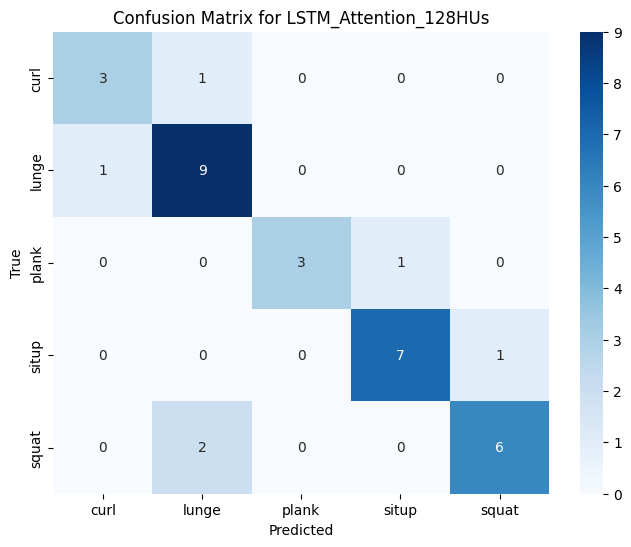

In [33]:
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1)
    yhat = np.argmax(yhat, axis=1)
    
    # Create a combined confusion matrix
    cm = confusion_matrix(ytrue, yhat)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [30]:
# Collect results 
eval_results['confusion matrix'] = confusion_matrices

for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")


LSTM_Attention_128HUs classification accuracy = 82.353%


In [31]:
# Collect results 
eval_results['accuracy'] = classification_accuracies

for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Get unique labels for proper classification report
    unique_labels = np.unique(np.concatenate([ytrue, yhat]))
    present_actions = [actions[i] for i in unique_labels]
    
    # Precision, recall, and f1 score
    try:
        report = classification_report(ytrue, yhat, labels=unique_labels, target_names=present_actions, output_dict=True)
        
        precisions[model_name] = report['weighted avg']['precision']
        recalls[model_name] = report['weighted avg']['recall']
        f1_scores[model_name] = report['weighted avg']['f1-score'] 
       
        print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
        print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
        print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")
    except Exception as e:
        print(f"Could not generate detailed metrics for {model_name}: {e}")
        # Use basic accuracy as fallback
        precisions[model_name] = classification_accuracies[model_name]
        recalls[model_name] = classification_accuracies[model_name]
        f1_scores[model_name] = classification_accuracies[model_name]


LSTM_Attention_128HUs weighted average precision = 0.834
LSTM_Attention_128HUs weighted average recall = 0.824
LSTM_Attention_128HUs weighted average f1-score = 0.824



In [32]:
# Collect results 
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

model = AttnLSTM
model_name = 'AttnLSTM'

In [ ]:
def calculate_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [ ]:
def get_coordinates(landmarks, mp_pose, side, joint):
    """
    Retrieves x and y coordinates of a particular keypoint from the pose estimation model
         
     Args:
         landmarks: processed keypoints from the pose estimation model
         mp_pose: Mediapipe pose estimation model
         side: 'left' or 'right'. Denotes the side of the body of the landmark of interest.
         joint: 'shoulder', 'elbow', 'wrist', 'hip', 'knee', or 'ankle'. Denotes which body joint is associated with the landmark of interest.
    """
    coord = getattr(mp_pose.PoseLandmark,side.upper()+"_"+joint.upper())
    x_coord_val = landmarks[coord.value].x
    y_coord_val = landmarks[coord.value].y
    return [x_coord_val, y_coord_val]

In [ ]:
def viz_joint_angle(image, angle, joint):
    """
    Displays the joint angle value near the joint within the image frame
    """
    cv2.putText(image, str(int(angle)), 
                   tuple(np.multiply(joint, [640, 480]).astype(int)), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
    return

In [ ]:
def count_reps(image, current_action, landmarks, mp_pose):
    """
    Counts repetitions of each exercise. Global count and stage (i.e., state) variables are updated within this function.
    Updated for: curl, push up, and plank exercises
    """

    global curl_counter, squat_counter, plank_counter, curl_stage, squat_stage, plank_stage, plank_start_time
    
    if current_action == 'curl':
        # Get coords for bicep curl
        shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist = get_coordinates(landmarks, mp_pose, 'left', 'wrist')
        
        # Calculate elbow angle
        angle = calculate_angle(shoulder, elbow, wrist)
        
        # Curl counter logic
        if angle < 30:
            curl_stage = "up" 
        if angle > 140 and curl_stage =='up':
            curl_stage="down"  
            curl_counter +=1
        
        # Reset other stages
        pushup_stage = None
        plank_stage = None
            
        # Viz joint angle
        viz_joint_angle(image, angle, elbow)
        
    elif current_action == 'squat':
        left_hip = get_coordinates(landmarks, mp_pose, 'left', 'hip')
        left_knee = get_coordinates(landmarks, mp_pose, 'left', 'knee')
        left_ankle = get_coordinates(landmarks, mp_pose, 'left', 'ankle')
        
        right_hip = get_coordinates(landmarks, mp_pose, 'right', 'hip')
        right_knee = get_coordinates(landmarks, mp_pose, 'right', 'knee')
        right_ankle = get_coordinates(landmarks, mp_pose, 'right', 'ankle')
        
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
        
        avg_knee_angle = (left_knee_angle + right_knee_angle) / 2
        
        if avg_knee_angle < 90:
            squat_stage = "down"
        if avg_knee_angle > 160 and squat_stage == 'down':
            squat_stage = "up"
            squat_counter += 1
        
        curl_stage = None
        plank_stage = None
        
        viz_joint_angle(image, left_knee_angle, left_knee)
        viz_joint_angle(image, right_knee_angle, right_knee)
     
    elif current_action == 'plank':
        # Get coords for plank
        left_shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        left_elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        left_hip = get_coordinates(landmarks, mp_pose, 'left', 'hip')
        left_knee = get_coordinates(landmarks, mp_pose, 'left', 'knee')
        left_ankle = get_coordinates(landmarks, mp_pose, 'left', 'ankle')
        
        # Calculate body alignment angles
        shoulder_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
        hip_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        
        # Plank detection logic - check if body is straight and parallel to ground
        # Good plank: shoulder-hip-knee should be close to 180 degrees (straight line)
        body_straight = shoulder_hip_angle > 160 and hip_knee_angle > 160
        
        # Check if person is in horizontal position (plank position)
        # Compare shoulder and hip y-coordinates (should be roughly similar)
        horizontal_position = abs(left_shoulder[1] - left_hip[1]) < 0.1
        
        if body_straight and horizontal_position:
            if plank_stage != "holding":
                plank_stage = "holding"
                plank_start_time = time.time()  # Start timing
        else:
            if plank_stage == "holding":
                # Calculate hold duration
                hold_duration = time.time() - plank_start_time
                if hold_duration > 3:  # Minimum 3 seconds to count as a plank
                    plank_counter += 1
                plank_stage = "not_holding"
        
        # Reset other stages
        curl_stage = None
        squat_stage = None
        
        # Viz joint angles
        viz_joint_angle(image, shoulder_hip_angle, left_hip)
        viz_joint_angle(image, hip_knee_angle, left_knee)
        
        # Display plank timer if holding
        if plank_stage == "holding":
            current_hold_time = time.time() - plank_start_time
            cv2.putText(image, f'Hold: {current_hold_time:.1f}s', (10, 400), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        pass

In [ ]:
def prob_viz(res, actions, input_frame, colors):
    """
    This function displays the model prediction probability distribution over the set of exercise classes
    as a horizontal bar graph
    """
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame


In [ ]:
# 1. New detection variables
sequence = []
predictions = []
res = []
threshold = 0.5 # minimum confidence to classify as an action/exercise
current_action = ''

# Rep counter logic variables - updated for your exercises
curl_counter = 0
squat_counter = 0
plank_counter = 0
curl_stage = None
squat_stage = None
plank_stage = None
plank_start_time = 0

# Camera object
cap = cv2.VideoCapture(0)

In [ ]:
# Video writer object that saves a video of the real time test
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') # video compression format
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

video_name = os.path.join(os.getcwd(),f"{model_name}_real_time_test.avi")
out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), FPS, (WIDTH,HEIGHT))

In [ ]:
# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)        
        sequence.append(keypoints)      
        sequence = sequence[-sequence_length:]
              
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]           
            predictions.append(np.argmax(res))
            current_action = actions[np.argmax(res)]
            confidence = np.max(res)
            
        #3. Viz logic
            # Erase current action variable if no probability is above threshold
            if confidence < threshold:
                current_action = ''

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
            # Count reps
            try:
                landmarks = results.pose_landmarks.landmark
                count_reps(image, current_action, landmarks, mp_pose)
            except:
                pass

            # Display graphical information - updated for your exercises
            cv2.rectangle(image, (0,0), (640, 40), colors[np.argmax(res)], -1)
            cv2.putText(image, 'curl ' + str(curl_counter), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'pushup ' + str(pushup_counter), (200,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'plank ' + str(plank_counter), (420,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
         
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Write to video file
        if ret == True:
            out.write(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
def process_video_with_model(input_video_path, model_path, actions, output_video_path=None):
    """
    Process a video file with the trained exercise recognition model
    
    Args:
        input_video_path: Path to input video file
        model_path: Path to trained model (.h5 file)
        actions: List of exercise action names
        output_video_path: Path to save output video (optional)
    """
    
    # Load the trained model
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
    
    # Model parameters (should match training parameters)
    sequence_length = 30
    threshold = 0.5
    
    # Colors for visualization (should match training colors)
    colors = [(245,117,16), (117,245,16), (16,117,245)]
    while len(colors) < len(actions):
        colors.append((np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)))
    
    # Initialize detection variables
    sequence = []
    predictions = []
    res = []
    current_action = ''
    
    # Initialize rep counters
    global curl_counter, squat_counter, plank_counter, curl_stage, squat_stage, plank_stage, plank_start_time
    curl_counter = 0
    squat_counter = 0
    plank_counter = 0
    curl_stage = None
    squat_stage = None
    plank_stage = None
    plank_start_time = 0
    
    # Open input video
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Setup output video writer if output path is provided
    out = None
    if output_video_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        print(f"Output video will be saved to: {output_video_path}")
    
    frame_count = 0
    
    # Process video with MediaPipe pose detection
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            if not ret:
                break
            
            frame_count += 1
            print(f"Processing frame {frame_count}/{total_frames}", end='\r')
            
            # Make detection
            image, results = mediapipe_detection(frame, pose)
            
            # Draw landmarks
            draw_landmarks(image, results)
            
            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-sequence_length:]
            if len(sequence) == sequence_length:
                res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]
                predictions.append(np.argmax(res))
                
                # FIX: Add bounds checking for action index
                predicted_index = np.argmax(res)
                if predicted_index < len(actions):
                    current_action = actions[predicted_index]
                else:
                    print(f"Warning: Model predicted class {predicted_index} but only {len(actions)} actions available")
                    current_action = 'unknown'
                
                confidence = np.max(res)
                
                # Erase current action variable if no probability is above threshold
                if confidence < threshold:
                    current_action = ''
                
                # Visualize probabilities (only for valid actions)
                if predicted_index < len(actions):
                    image = prob_viz(res[:len(actions)], actions, image, colors[:len(actions)])
                
                # Count reps
                try:
                    landmarks = results.pose_landmarks.landmark
                    count_reps(image, current_action, landmarks, mp_pose)
                except:
                    pass
                
                # Display graphical information
                if predicted_index < len(actions):
                    cv2.rectangle(image, (0,0), (width, 40), colors[predicted_index], -1)
                else:
                    cv2.rectangle(image, (0,0), (width, 40), (128, 128, 128), -1)  # Gray for unknown
                
                cv2.putText(image, f'Curl: {curl_counter}', (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f'Squat: {squat_counter}', (200, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f'Plank: {plank_counter}', (420, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
                # Display current action and confidence
                cv2.putText(image, f'Action: {current_action} ({confidence:.2f})', (10, height-20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Write frame to output video if specified
            if out is not None:
                out.write(image)
            
            # Display frame (optional - comment out for faster processing)
            cv2.imshow('Exercise Recognition', image)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    # Cleanup
    cap.release()
    if out is not None:
        out.release()
    cv2.destroyAllWindows()
    
    # Print final results
    print(f"\nProcessing complete!")
    print(f"Final counts:")
    print(f"  Curls: {curl_counter}")
    print(f"  Squats: {squat_counter}")
    print(f"  Planks: {plank_counter}")
    
    if output_video_path:
        print(f"Output video saved to: {output_video_path}")


In [ ]:
if __name__ == "__main__":
    # Configuration - UPDATE THESE PATHS
    INPUT_VIDEO_PATH = r"C:\Users\pheno\Downloads\work\main_model\2nd test vid.mp4"  # Change this to your input video path
    MODEL_PATH = "LSTM_Attention_128HUs.h5"  # Path to your trained model
    OUTPUT_VIDEO_PATH = "output_exercise_recognition.mp4"  # Where to save the output video
    
    # Actions (should match your training data)
    # Update this list to match the actions you trained your model on
    actions = np.array(['curl','squat','plank'])  # Modify based on your training data
    
    # Check if files exist
    if not os.path.exists(INPUT_VIDEO_PATH):
        print(f"Error: Input video file not found: {INPUT_VIDEO_PATH}")
        print("Please update INPUT_VIDEO_PATH with the correct path to your video file.")
    elif not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found: {MODEL_PATH}")
        print("Please update MODEL_PATH with the correct path to your trained model.")
    else:
        # Process the video
        process_video_with_model(
            input_video_path=INPUT_VIDEO_PATH,
            model_path=MODEL_PATH,
            actions=actions,
            output_video_path=OUTPUT_VIDEO_PATH
        )